#### Measuring Expectation values & run a batch of circuits

In [167]:
import numpy as np

from braket.circuits import Circuit, Observable
from braket.quantum_information import PauliString
from braket.parametric import FreeParameter

In [169]:
# Create a small circuit with a free parameter theta
theta = FreeParameter("theta")
pauli_string = PauliString('XY')
pauli_operator = pauli_string.to_unsigned_observable()

circ = Circuit()
circ.rx(0, theta)
circ.expectation(observable=pauli_operator, target=[0, 1])

# Small value for test purposes
batchsize = 5
batch_circuits = [circ] * batchsize

In [171]:
print(circ)

T  : |    0    |  Result Types  |
                                 
q0 : -Rx(theta)-Expectation(X@Y)-
                |                
q1 : -----------Expectation(X@Y)-

T  : |    0    |  Result Types  |

Unassigned parameters: [theta].


In [172]:
thetas = np.arange(0.0*np.pi, 2.5*np.pi, np.pi/2).tolist()[:batchsize]

from braket.devices import LocalSimulator

device = LocalSimulator()

job = device.run(circ, shots=100, inputs={'theta': thetas[0]})

# Run multiple circuits at once
job = device.run_batch(
#     batch_circuits,
#     inputs={'theta': thetas}, 
#     shots=100
# )
job.result()

GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='0eaf34b9-0d3a-42b6-961a-cf1efe1c3e15', shots=100, deviceId='braket_sv', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='OPENQASM 3.0;\ninput float theta;\nqubit[2] q;\nrx(theta) q[0];\n#pragma braket result expectation x(q[0]) @ y(q[1])', inputs={'theta': 0.0}), dwaveMetadata=None, ionqMetadata=None, rigettiMetadata=None, oqcMetadata=None, xanaduMetadata=None, queraMetadata=None, simulatorMetadata=None), result_types=[ResultTypeValue(type=Expectation(observable=['x', 'y'], targets=[0, 1], type=<Type.expectation: 'expectation'>), value=-0.08)], values=[-0.08], measurements=array([[0, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       

#### Custom Pulse-Calibrations

In [1]:
import os
import sys

from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.local import LocalQuantumJob
from braket.jobs.image_uris import Framework, retrieve_image
from qiskit_braket_provider.providers import adapter
from braket.circuits import Gate, Instruction, Circuit

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")

module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from needed_files.quantumenvironment import QuantumEnvironment
from needed_files.helper_functions import load_agent_from_yaml_file
from needed_files.ppo import make_train_ppo
from needed_files.q_env_config import q_env_config as gate_q_env_config
from needed_files.pulse_config import q_env_config as pulse_q_env_config

import time

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(
I0000 00:00:1706511406.301765       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'rz', 'id', 'reset', 'delay', 'sx', 'h', 's', 'z', 'tdg', 'measure', 'x', 't', 'sdg'}
  q1: {'rz', 'id', 'reset', 'delay', 'sx', 'h', 's', 'z', 'tdg', 'measure', 'x', 't', 'sdg'}
Multi qubit instructions:
  (0, 1): {'cr45m', 'ecr', 'cr45p'}
  (1, 0): {'cr45m', 'ecr', 'cr45p'}
)>


In [3]:
q_env = QuantumEnvironment(pulse_q_env_config)

SparsePauliOp(['I', 'X'],
              coeffs=[0.5+0.j, 0.5+0.j])


In [5]:
print('Target Gate:', q_env.target['gate'].name)

Target Gate: x


/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


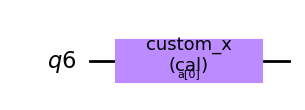

In [8]:
q_env.circuit_truncations[0].draw('mpl')

In [9]:
q_env.parametrized_circuit_func

<function needed_files.pulse_config.apply_parametrized_circuit(qc: 'QuantumCircuit', params: 'ParameterVector', tgt_register: 'QuantumRegister', **kwargs)>

In [ ]:
# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, tgt_register: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param tgt_register: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     backend = kwargs["backend"]

#     gate, physical_qubits = target["gate"], target["register"]
#     parametrized_gate = Gate(
#         f"custom_{gate.name}", len(tgt_register), params=params.params
#     )
#     parametrized_schedule = custom_schedule(
#         backend=backend, physical_qubits=physical_qubits, params=params
#     )
#     qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
#     qc.append(parametrized_gate, tgt_register)

In [69]:
from typing import List, Optional, Union, cast
from qiskit import QuantumCircuit

In [173]:
def apply_parametrized_circuit_aws(
        qc: Union[Circuit, QuantumCircuit], target, backend
):
    if isinstance(qc, QuantumCircuit):
        qc = adapter.convert_qiskit_to_braket_circuit(qc)

    # target = kwargs["target"]
    # backend = kwargs["backend"]

    gate, physical_qubits = target["gate"], target["register"]

    own_gate = Gate(
       qubit_count=len(physical_qubits), ascii_symbols=str.upper(gate.name)
    )

    qc.add_instruction(Instruction(own_gate, physical_qubits))

    print('qc:', qc)

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


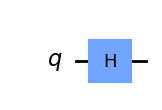

In [174]:
# Start with a qiskit circuit
qc = QuantumCircuit(1)
qc.h(0)
qc.draw('mpl')

In [175]:
apply_parametrized_circuit_aws(qc, target=q_env.target, backend=q_env.backend)

qc: T  : |0|1|
          
q0 : -H-X-

T  : |0|1|


In [183]:
physical_qubits = q_env.target['register']
gate = q_env.target['gate'].name

In [39]:
own_gate = Gate(
    qubit_count=len(physical_qubits), ascii_symbols=str.upper(gate.name)
)

In [40]:
own_gate.name

'Gate'

In [41]:
my_circuit = Circuit().add_instruction(Instruction(own_gate, physical_qubits))
print(my_circuit)

T  : |0|
        
q0 : -X-

T  : |0|


In [34]:
from braket.aws import AwsDevice

from braket.pulse import PulseSequence
from braket.circuits import Circuit, GateCalibrations, QubitSet
from braket.circuits.gates import X

import math

In [59]:
# XXX: OQC does not support native gate calibration !
# device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")

device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

In [60]:
calibrations = device.gate_calibrations
print(
    f"The number of pulse implementations in the calibration file is {len(calibrations)}."
)

The number of pulse implementations in the calibration file is 925.


In [66]:
calibrations.pulse_sequences

{(Rx('angle': 1.5707963267948966, 'qubit_count': 1),
  QubitSet([Qubit(0)])): <braket.pulse.pulse_sequence.PulseSequence at 0x32db585b0>,
 (Rx('angle': -1.5707963267948966, 'qubit_count': 1),
  QubitSet([Qubit(0)])): <braket.pulse.pulse_sequence.PulseSequence at 0x32db58460>,
 (Rx('angle': 3.141592653589793, 'qubit_count': 1),
  QubitSet([Qubit(0)])): <braket.pulse.pulse_sequence.PulseSequence at 0x32db52410>,
 (Rx('angle': -3.141592653589793, 'qubit_count': 1),
  QubitSet([Qubit(0)])): <braket.pulse.pulse_sequence.PulseSequence at 0x32db53880>,
 (Rz('angle': theta, 'qubit_count': 1),
  QubitSet([Qubit(0)])): <braket.pulse.pulse_sequence.PulseSequence at 0x32db50850>,
 (Rx('angle': 1.5707963267948966, 'qubit_count': 1),
  QubitSet([Qubit(100)])): <braket.pulse.pulse_sequence.PulseSequence at 0x32db47580>,
 (Rx('angle': -1.5707963267948966, 'qubit_count': 1),
  QubitSet([Qubit(100)])): <braket.pulse.pulse_sequence.PulseSequence at 0x32db464a0>,
 (Rx('angle': 3.141592653589793, 'qubit_co

In [190]:
list(calibrations.pulse_sequences.keys())[0]

(Rx('angle': 1.5707963267948966, 'qubit_count': 1), QubitSet([Qubit(0)]))

In [193]:
calibrations.pulse_sequences[list(calibrations.pulse_sequences.keys())[0]]

#### Build own Pulse Schedules